In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from pytorchtools import EarlyStopping

In [2]:
scaler = MinMaxScaler(feature_range=(0, 1))

### 导入数据

In [5]:
df2 = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)
df2

,日期,DATA_DT,内存负载,主机CPU平均负载
0,2020-03-01 01:00:00,1582995600,81.8242,2.8333
1,2020-03-01 02:00:00,1582999200,81.8145,3.1818
2,2020-03-01 03:00:00,1583002800,81.8092,3.0833
3,2020-03-01 04:00:00,1583006400,81.8042,3.0833
4,2020-03-01 05:00:00,1583010000,81.8333,2.5000
...,...,...,...,...
2202,2020-05-31 19:00:00,1590922800,70.6183,2.0000
2203,2020-05-31 20:00:00,1590926400,70.5208,1.9167
2204,2020-05-31 21:00:00,1590930000,70.5608,1.7500
2205,2020-05-31 22:00:00,1590933600,70.5292,2.0000


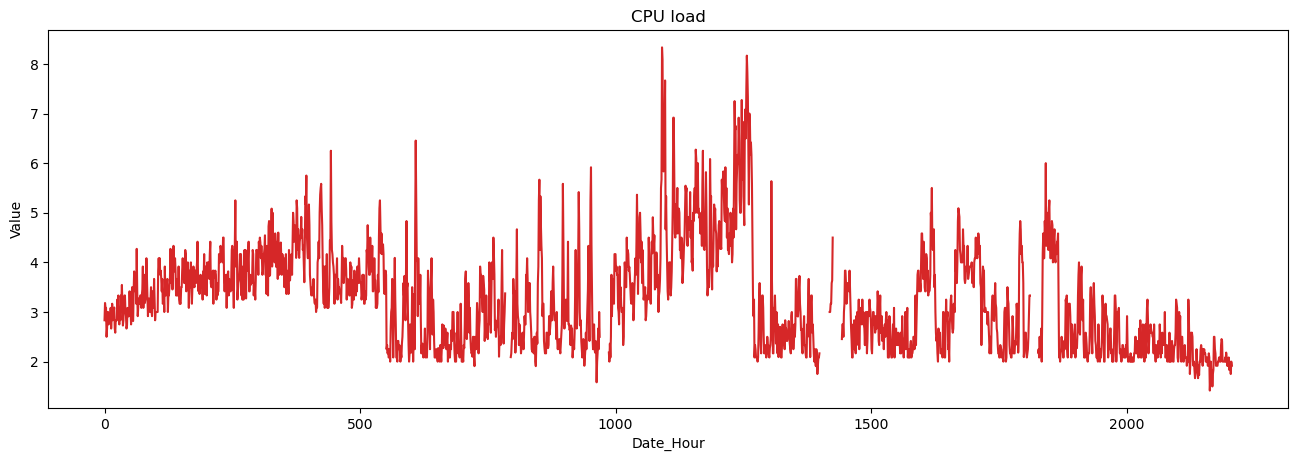

In [4]:
# Draw Plot-----绘图函数
def plot_df(df2, x, y, title="", xlabel='Date_Hour', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df2, x=df2.index, y= df2["主机CPU平均负载"], title='CPU load')

### 缺失值填充

In [5]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df2["主机CPU平均负载"] = knn_mean(df2["主机CPU平均负载"], 24)

In [6]:
df = df2.copy(deep=True) 

In [7]:
# 滞后阶数
num_hour = 336
data = df["主机CPU平均负载"]
dataframe = pd.DataFrame()
for i in range(num_hour,0,-1):
    dataframe['t-'+str(i)] = data.shift(i)
dataframe['t'] = data.values
dataframe

,t-336,t-335,t-334,t-333,t-332,t-331,t-330,t-329,t-328,t-327,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8333
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8333,3.1818
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8333,3.1818,3.0833
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.8333,3.1818,3.0833,3.0833
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.8333,3.1818,3.0833,3.0833,2.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,4.5833,3.4167,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,...,2.0833,2.0000,2.1818,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000
2203,3.4167,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,2.0833,...,2.0000,2.1818,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000,1.9167
2204,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,2.0833,2.0833,...,2.1818,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000,1.9167,1.7500
2205,2.1667,2.0000,2.1667,2.2500,2.5000,2.2500,2.3333,2.0833,2.0833,2.4167,...,2.0833,1.9167,2.0000,1.9167,2.0833,1.8333,2.0000,1.9167,1.7500,2.0000


### 测试集和训练集

In [8]:
# all_data = dataframe[num_hour:]
# all_data = shuffle(all_data) 
# all_data.to_csv('shuffle.csv')
all_data = pd.read_csv(r"C:\Code\Python\PycharmProjects\数据分析\数据分析\shuffle.csv",index_col=0)
all_data

,t-336,t-335,t-334,t-333,t-332,t-331,t-330,t-329,t-328,t-327,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
510,3.9167,3.5833,3.5000,3.7500,3.8333,3.5833,3.8182,4.0000,4.4167,3.7500,...,3.6000,3.5833,3.2500,3.3333,3.7500,3.4167,3.7500,3.1667,3.1667,3.4167
854,3.7500,3.7500,4.5000,3.9167,3.8182,3.9167,4.3333,3.4167,3.4167,3.6667,...,2.3333,2.5833,2.3636,3.5833,3.9167,5.2500,5.6667,4.2500,5.3333,4.7500
1720,3.3333,2.5833,2.7500,2.5000,2.1667,2.0000,2.2500,2.0000,1.9091,2.2500,...,4.5000,4.1667,4.3333,3.5833,3.5000,2.3333,2.9167,3.6667,3.9167,3.8333
1564,4.0000,4.1667,5.0833,4.5000,5.9091,7.2500,6.6667,6.7500,4.6667,5.5833,...,2.5000,2.4167,2.1667,2.5833,2.1667,2.3333,2.9167,2.2500,2.3333,2.0833
526,3.6667,3.5833,3.2500,3.8182,3.6667,4.1667,3.3636,3.5000,3.9167,3.8333,...,3.9167,3.7500,3.7500,4.5000,3.9167,3.8182,3.9167,4.3333,3.4167,3.4167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,2.8333,2.3333,2.1667,2.0833,2.0833,2.5000,2.7500,2.3333,3.0833,2.0833,...,4.4167,4.4167,4.5833,3.4167,2.0833,2.1667,2.0000,2.1667,2.2500,2.5000
2055,3.9167,3.8333,3.8333,3.0000,3.0833,3.0833,3.0000,3.0000,3.0000,2.7500,...,2.5833,2.7500,2.6667,2.5833,2.5833,2.5000,2.5000,2.1667,2.7500,2.1667
1356,3.5000,3.5000,4.5000,3.9167,4.2500,4.1667,3.8333,3.9091,3.7500,3.5000,...,2.3636,2.2500,2.3333,2.7500,2.5000,2.7500,3.6667,3.6667,3.2500,2.9167
2045,4.4167,4.5833,4.5000,4.1667,4.3333,3.5833,3.5000,2.3333,2.9167,3.6667,...,2.3333,2.7500,2.0833,2.6667,3.0833,3.2500,2.8333,2.1667,2.3333,2.5833


In [9]:
var1 = int(len(all_data)*0.6)
var2 = int(len(all_data)*0.8)
train_data = all_data[0:var1]
validate_data = all_data[var1:var2]
test_data = all_data[var2:]
# train_data
# test_data
# validate_data

In [10]:
max_value = max(train_data.max().values)
min_value = min(train_data.min().values)
ch = max_value - min_value

### 归一化

In [11]:
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))
train_data_normalized = train_data_normalized.reshape(-1,num_hour+1)
train_data_normalized.shape

(1122, 337)

In [12]:
validate_data_normalized = scaler.transform(validate_data.values.reshape(-1, 1))
validate_data_normalized = validate_data_normalized.reshape(-1,num_hour+1)
validate_data_normalized.shape

(374, 337)

In [13]:
test_data_normalized = scaler.transform(test_data.values.reshape(-1, 1))
test_data_normalized = test_data_normalized.reshape(-1,num_hour+1)
test_data_normalized.shape

(375, 337)

In [14]:
train_X = torch.Tensor(train_data_normalized[:,0:-1].reshape(-1, 14, 24))
train_Y = torch.Tensor(train_data_normalized[:,-1].reshape(-1, 1, 1))
train_Y.shape

torch.Size([1122, 1, 1])

In [15]:
validate_X = torch.Tensor(validate_data_normalized[:,0:-1].reshape(-1, 14, 24))
validate_Y = torch.Tensor(validate_data_normalized[:,-1].reshape(-1, 1, 1))
validate_X.shape

torch.Size([374, 14, 24])

In [16]:
test_X = torch.Tensor(test_data_normalized[:,0:-1].reshape(-1, 14, 24))
test_Y = torch.Tensor(test_data_normalized[:,-1].reshape(-1, 1, 1))
test_X.shape

torch.Size([375, 14, 24])

In [17]:
# train_data_temp = torch.utils.data.TensorDataset(train_X, train_Y)
# test_data_temp = torch.utils.data.TensorDataset(test_X, test_Y)
# train_data = DataLoader(train_data_temp, batch_size=256, shuffle=True, num_workers=1)#训练数据
# test_data = DataLoader(test_data_temp, batch_size=256, shuffle=False, num_workers=2)#测试数据

In [18]:
start = time.time()

### 建立LSTM模型

In [19]:
class BatchNorm(nn.Module):
    def forward(self, x):
        return 2 * x - 1

class DynamicReLU_A(nn.Module):
    def __init__(self, channels, K=2,ratio=6):
        super(DynamicReLU_A, self).__init__()
        mid_channels = 2*K

        self.K = K
        self.lambdas = torch.Tensor([1.]*K + [0.5]*K).float()
        self.init_v = torch.Tensor([1.] + [0.]*(2*K - 1)).float()

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.dynamic = nn.Sequential(
            nn.Linear(in_features=channels,out_features=channels // ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=channels // ratio, out_features=mid_channels),
            nn.Sigmoid(),
            BatchNorm()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        z = self.dynamic(y)

        relu_coefs = z.view(-1, 2 * self.K) * self.lambdas + self.init_v
        x_perm = x.transpose(0, -1).unsqueeze(-1)
        output = x_perm * relu_coefs[:, :self.K] + relu_coefs[:, self.K:]

        output = torch.max(output, dim=-1)[0].transpose(0, -1)
        return output

class lstm(nn.Module):
    def __init__(self,input_size=16,hidden_size=100,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer,batch_first=True)
        self.layer2 = nn.Linear(hidden_size*14,output_size)
    
#     def forward(self,x):
#         x,_ = self.layer1(x)
# #         x = x[:,[13],:]
#         b, s, h = x.size()
#         model_temp = DynamicReLU_A(b)
#         x = x.reshape(1,b,s,h)
#         x = model_temp(x)
#         x = x.reshape(-1,s*h)
#         x = self.layer2(x)
#         x = x.reshape(b, 1, 1)
#         return x
    def forward(self,x):
        b, s, h = x.size()
        model_temp = DynamicReLU_A(s)
        x = x.reshape(b,s,h,1)
        x = model_temp(x)
        x = x.reshape(b,s,h)
        x,_ = self.layer1(x)
        b, s, h = x.size()
        x = x.reshape(-1,s*h)
        x = self.layer2(x)
        x = x.reshape(b, 1, 1)
        return x

model = lstm(24, 128, 1, 1)
model

lstm(
  (layer1): LSTM(24, 128, batch_first=True)
  (layer2): Linear(in_features=1792, out_features=1, bias=True)
)

In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epoch_n = 1000
# 初始化 early_stopping 对象
# 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
patience = 50  

# 关于 EarlyStopping 的代码可先看博客后面的内容
early_stopping = EarlyStopping(patience, verbose=True)

In [21]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(1, epoch_n+1):
    var_x = Variable(train_X)
    var_y = Variable(train_Y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if e % 10 == 0: # 每 10 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e, loss.item()))
    ep.append(e)
    losses.append(loss.item())
    
    valid_output = model(validate_X)
    valid_loss = criterion(valid_output, validate_Y)
    
    early_stopping(valid_loss, model)
    
    # 若满足 early stopping 要求
    if early_stopping.early_stop:
        print("Early stopping")
        # 结束模型训练
        break
    
#     break
#     if (e+1)%120 == 0:
#         for p in optimizer.param_groups:
#             p['lr'] *= 0.1
#     lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Validation loss decreased (inf --> 1.977551).  Saving model ...
Validation loss decreased (1.977551 --> 0.306488).  Saving model ...
EarlyStopping counter: 1 out of 50
Validation loss decreased (0.306488 --> 0.089164).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
EarlyStopping counter: 5 out of 50
Epoch: 10, Loss: 0.02830
Validation loss decreased (0.089164 --> 0.029207).  Saving model ...
Validation loss decreased (0.029207 --> 0.023359).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
EarlyStopping counter: 5 out of 50
Validation loss decreased (0.023359 --> 0.019392).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
Epoch: 20, Loss: 0.19796
EarlyStopping counter: 3 out of 50
Validation loss decreased (0.019392 --> 0.016192). 

EarlyStopping counter: 27 out of 50
EarlyStopping counter: 28 out of 50
Epoch: 200, Loss: 0.01417
EarlyStopping counter: 29 out of 50
Validation loss decreased (0.009066 --> 0.008951).  Saving model ...
EarlyStopping counter: 1 out of 50
EarlyStopping counter: 2 out of 50
EarlyStopping counter: 3 out of 50
EarlyStopping counter: 4 out of 50
EarlyStopping counter: 5 out of 50
EarlyStopping counter: 6 out of 50
EarlyStopping counter: 7 out of 50
EarlyStopping counter: 8 out of 50
Epoch: 210, Loss: 0.01401
EarlyStopping counter: 9 out of 50
EarlyStopping counter: 10 out of 50
EarlyStopping counter: 11 out of 50
EarlyStopping counter: 12 out of 50
EarlyStopping counter: 13 out of 50
EarlyStopping counter: 14 out of 50
EarlyStopping counter: 15 out of 50
EarlyStopping counter: 16 out of 50
EarlyStopping counter: 17 out of 50
EarlyStopping counter: 18 out of 50
Epoch: 220, Loss: 0.01747
EarlyStopping counter: 19 out of 50
EarlyStopping counter: 20 out of 50
EarlyStopping counter: 21 out of 5

EarlyStopping counter: 14 out of 50
EarlyStopping counter: 15 out of 50
EarlyStopping counter: 16 out of 50
EarlyStopping counter: 17 out of 50
EarlyStopping counter: 18 out of 50
Epoch: 410, Loss: 0.00929
EarlyStopping counter: 19 out of 50
EarlyStopping counter: 20 out of 50
EarlyStopping counter: 21 out of 50
EarlyStopping counter: 22 out of 50
EarlyStopping counter: 23 out of 50
EarlyStopping counter: 24 out of 50
EarlyStopping counter: 25 out of 50
EarlyStopping counter: 26 out of 50
EarlyStopping counter: 27 out of 50
EarlyStopping counter: 28 out of 50
Epoch: 420, Loss: 0.00945
EarlyStopping counter: 29 out of 50
EarlyStopping counter: 30 out of 50
EarlyStopping counter: 31 out of 50
EarlyStopping counter: 32 out of 50
EarlyStopping counter: 33 out of 50
EarlyStopping counter: 34 out of 50
EarlyStopping counter: 35 out of 50
EarlyStopping counter: 36 out of 50
EarlyStopping counter: 37 out of 50
EarlyStopping counter: 38 out of 50
Epoch: 430, Loss: 0.00898
EarlyStopping counter:

In [22]:
end = time.time()

In [23]:
time = end - start
print(f'运行时长为:{int(time)}s')

运行时长为:334s


In [24]:
# plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')

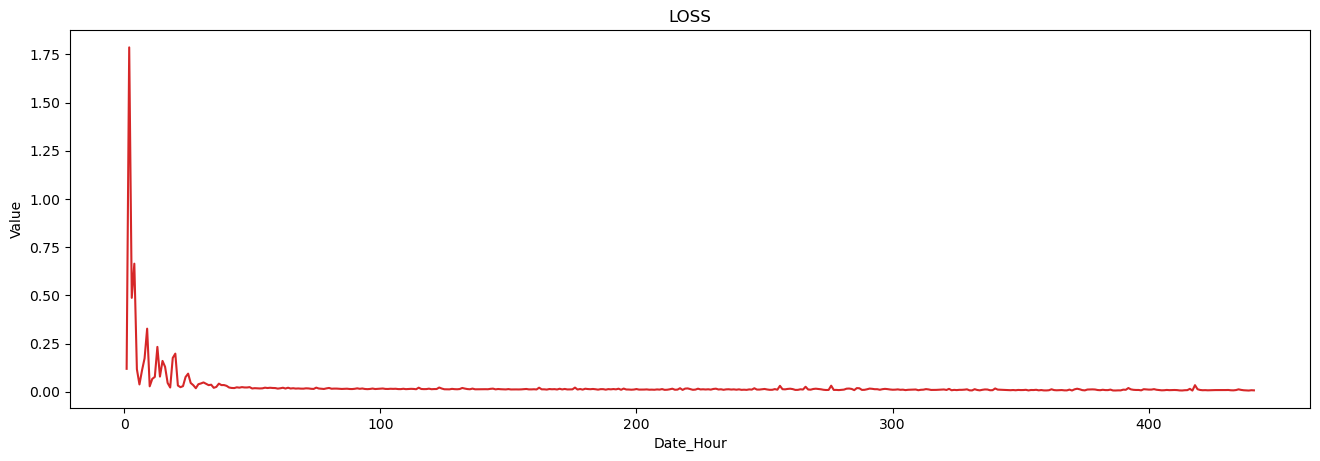

In [25]:
plot_df(df, x=ep, y= losses, title='LOSS')

In [26]:
torch.save(model, 'net.pkl')
model2 = torch.load('net.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


### 验证测试集

In [27]:
def rereal(list_temp, min_value, max_value):
    arr = []
    for dat in list_temp:
        temp = dat*(max_value-min_value) + min_value
        arr.append(temp)
    return arr

In [28]:
outputs = model2(test_X)
loss = criterion(outputs, test_Y)
loss

tensor(0.0112, grad_fn=<MseLossBackward>)

In [29]:
num = len(test_Y)

In [30]:
outputs = outputs.reshape(num)
y_pred_temp = outputs.detach().numpy()
tru_temp = test_Y.detach().numpy().reshape(num)
# # 二维转一维
# y_pred = []
# for i in range(len(y_pred_temp)):
#     y_pred.append(y_pred_temp[i])
# test_Y = test_Y.reshape(num)

In [31]:
MSE = 0
for i in range(num):
    MSE += (y_pred_temp[i] - tru_temp[i])**2
MSE /= num
MSE

0.01121960765489852

In [32]:
predict = rereal(y_pred_temp,min_value,max_value)
truth =  rereal(tru_temp,min_value,max_value)

In [33]:
# # 未还原归一化
# plt.figure(figsize=(16,5), dpi=100)
# plt.plot(range(num), y_pred, c='red', lw='1')
# plt.plot(range(num), tru_temp, c='blue', lw='1')

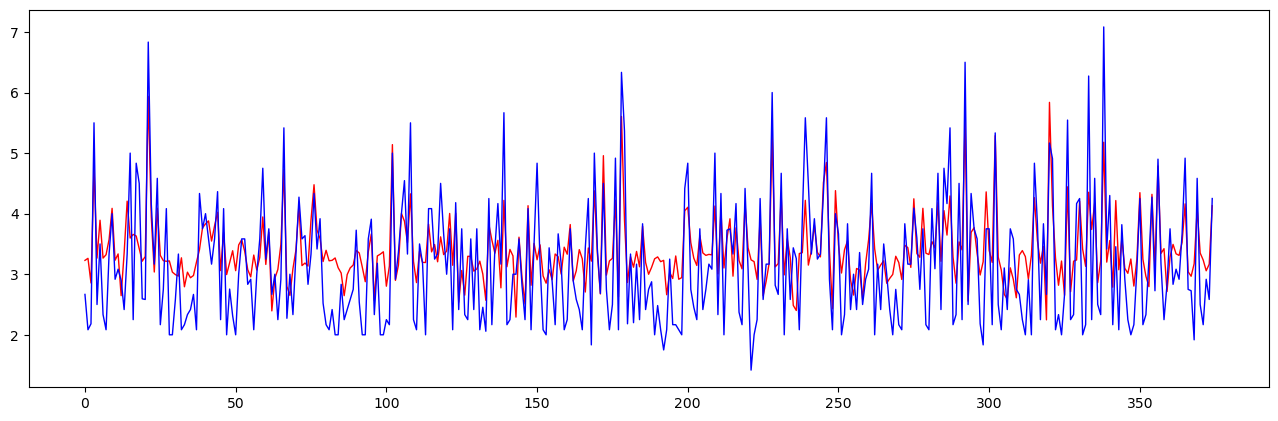

In [34]:
# 还原归一化
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), predict, c='red', lw='1')
plt.plot(range(num), truth, c='blue', lw='1')

In [35]:
# 求真实值与预测值的MSE
MSE = 0
for i in range(num):
    MSE += (predict[i] - truth[i])**2
MSE /= num
MSE

0.5367388045244712

(0.0, 3.0)

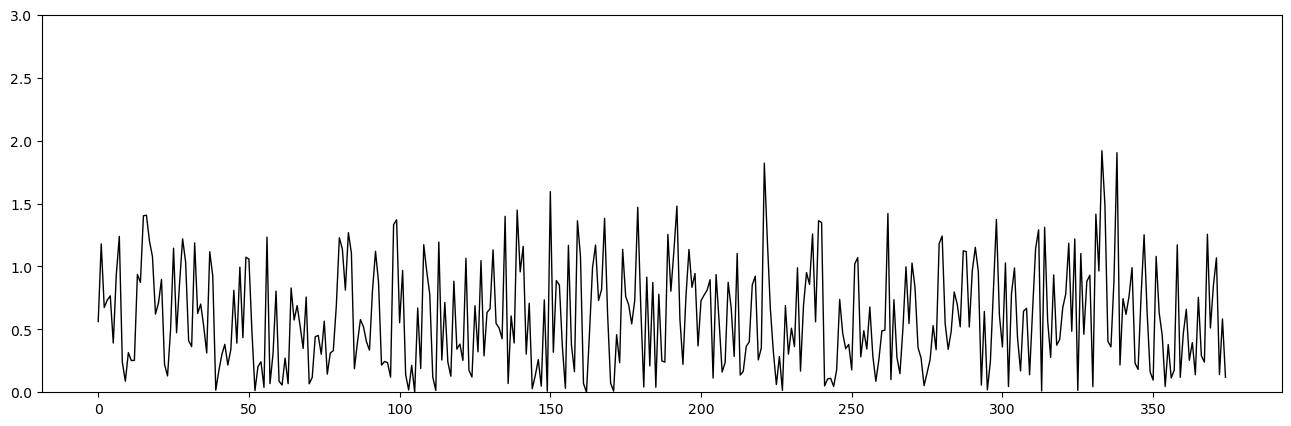

In [36]:
# 求真实值与预测值的误差值
errors = []
for i in range(num):
    error = abs(truth[i] - predict[i])
    errors.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors, c='black', lw='1')
plt.ylim(0,3)

(0.0, 70.0)

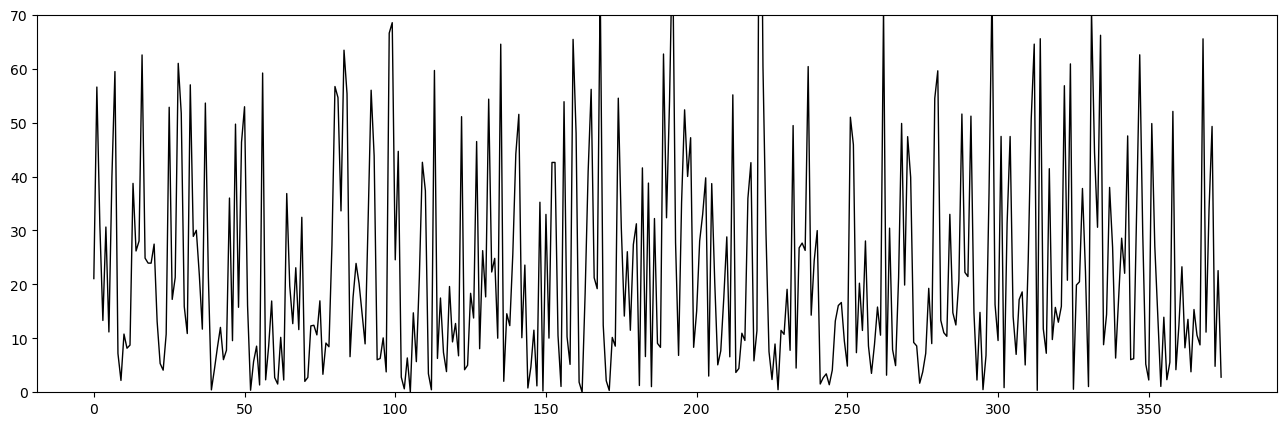

In [37]:
# 求真实值与预测值的误差值占原真实值的百分比
errors_p = []
for i in range(num):
    error = ((abs(truth[i] - predict[i]))/truth[i])*100
    errors_p.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors_p, c='black', lw='1')
plt.ylim(0,70)

In [38]:
from numpy import mean
mean(errors_p)

22.902028170110338

### 验证训练集

In [39]:
outputs = model2(train_X)
loss = criterion(outputs, train_Y)
loss

tensor(0.0071, grad_fn=<MseLossBackward>)

In [40]:
num = len(train_Y)

In [41]:
outputs = outputs.reshape(num)
y_pred_temp = outputs.detach().numpy()
tru_temp = train_Y.detach().numpy().reshape(num)

In [42]:
MSE = 0
for i in range(num):
    MSE += (y_pred_temp[i] - tru_temp[i])**2
MSE /= num
MSE

0.007076831526782065

In [43]:
predict = rereal(y_pred_temp,min_value,max_value)
truth =  rereal(tru_temp,min_value,max_value)

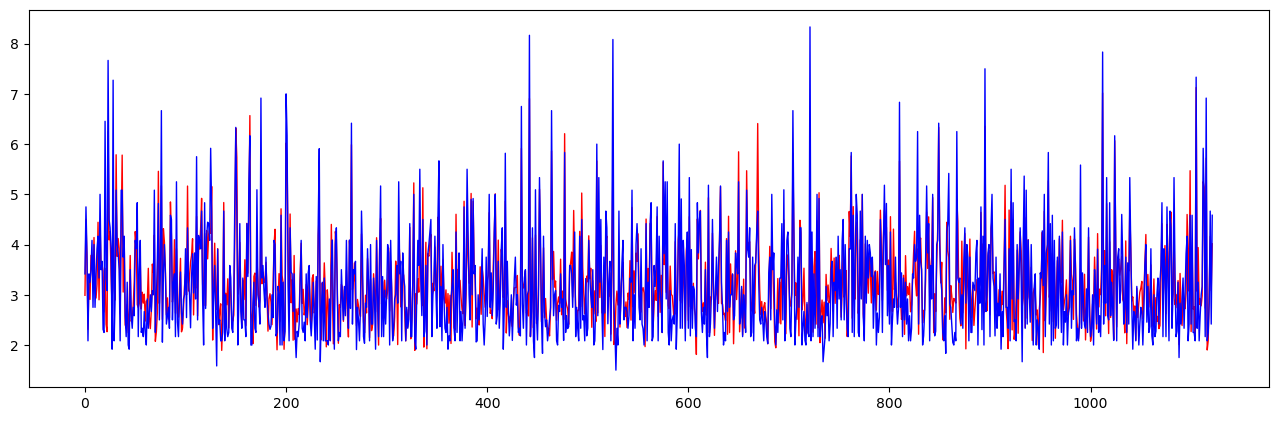

In [44]:
# 还原归一化
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), predict, c='red', lw='1')
plt.plot(range(num), truth, c='blue', lw='1')

In [45]:
# 求真实值与预测值的MSE
MSE = 0
for i in range(num):
    MSE += (predict[i] - truth[i])**2
MSE /= num
MSE

0.33855106069268803

(0.0, 3.0)

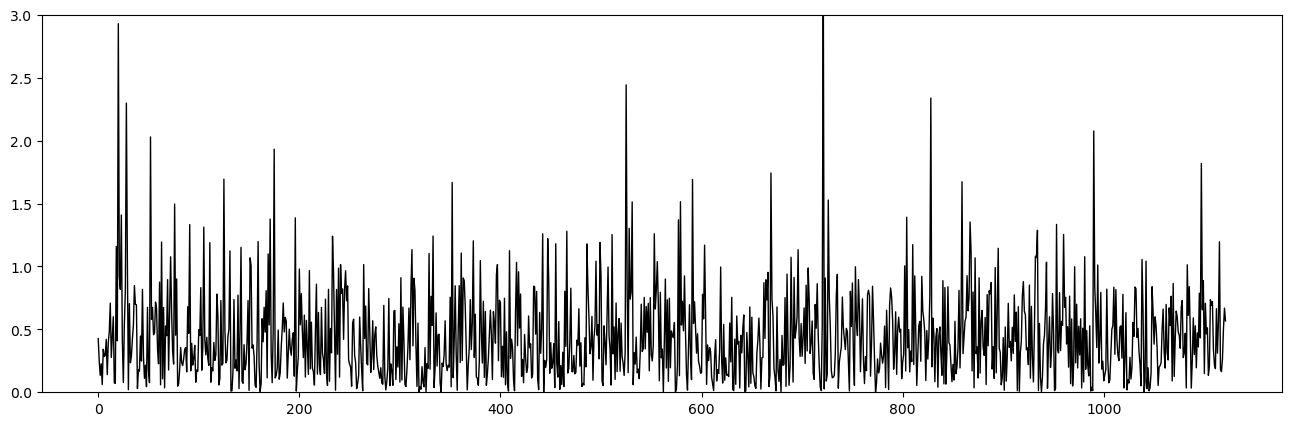

In [46]:
# 求真实值与预测值的误差值
errors = []
for i in range(num):
    error = abs(truth[i] - predict[i])
    errors.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors, c='black', lw='1')
plt.ylim(0,3)

(0.0, 70.0)

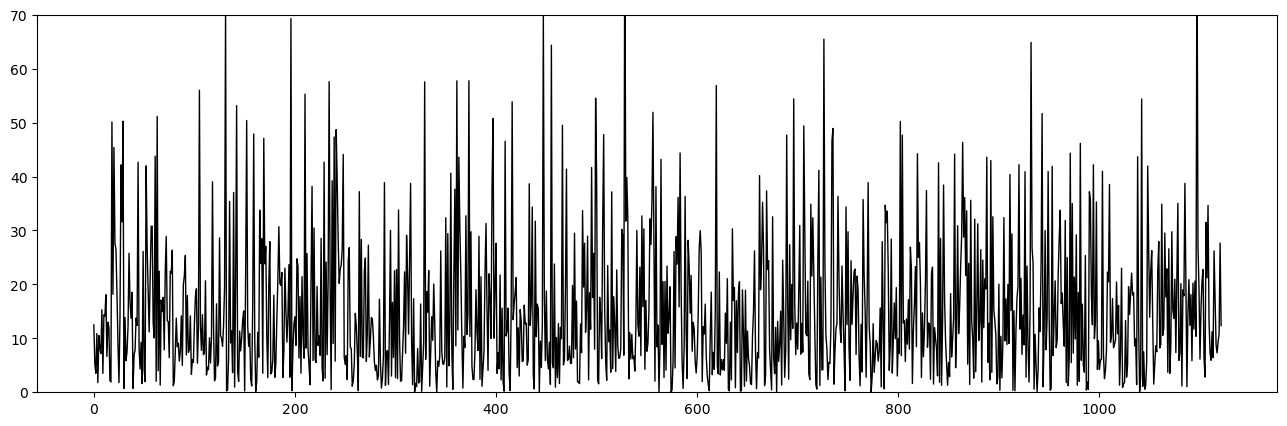

In [47]:
# 求真实值与预测值的误差值占原真实值的百分比
errors_p = []
for i in range(num):
    error = ((abs(truth[i] - predict[i]))/truth[i])*100
    errors_p.append(error)
plt.figure(figsize=(16,5), dpi=100)
plt.plot(range(num), errors_p, c='black', lw='1')
plt.ylim(0,70)

In [48]:
mean(errors_p)

15.402266559914786